The goal of this is to further understand how to use this using my simpler understanding of Python; the notes are a bit magical to me as to how they came to conclusions that they have ran into.

In [50]:
# for the sake of training speed, we're going to import one of the smallest built in models. 
# it still has a LOT of complexity, and over 3 million parameters
import numpy as np
import matplotlib.pyplot as plt

# Fetching the gradients is illegal with eager execution, so to produce the CAMs we
# must disable it. 
from tensorflow import compat
compat.v1.disable_eager_execution()

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.resnet50 import ResNet50



Abyssinian_223.jpg


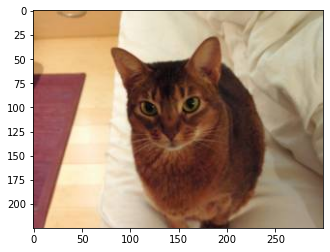

american_bulldog_138.jpg


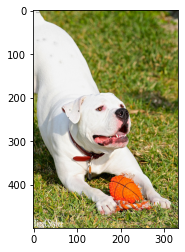

basset_hound_61.jpg


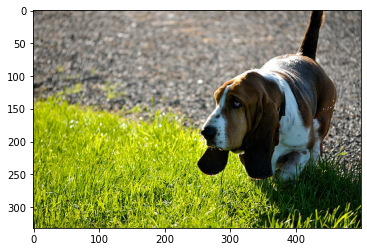

Capture.JPG


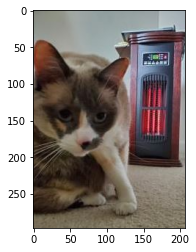

Capture.PNG


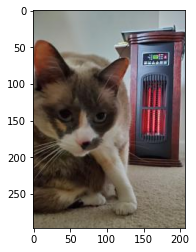

cat1.png


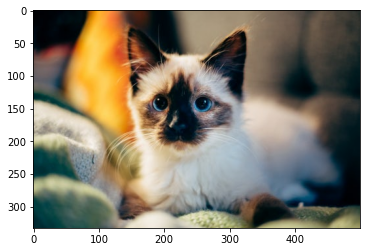

cat2.png


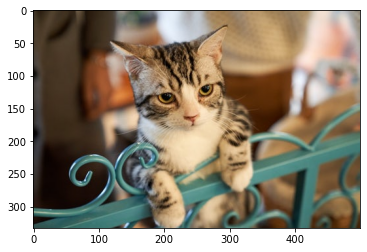

dog-cat1.png


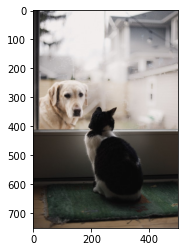

dog1.png


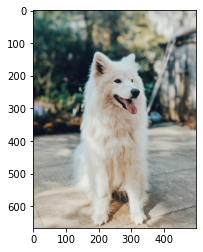

dog2.png


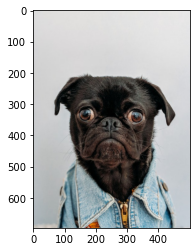

In [51]:
import os 
from tensorflow.keras.preprocessing import image as keras_image
photo_location = './photos/'


for name in os.listdir(photo_location):
    print(name)
    if name.startswith('.'): continue # Avoid looking at hidden files, which the OS sometimes puts in the folder
    image = keras_image.load_img(photo_location + name)
    plt.imshow(image)
    plt.show()

In [52]:
# We have to process each image to fit our networks expected input size... this can be a bit of a hassle.
# Keras provides an okay library function for doing this, but it squashes images rather than padding them.
# So this code pads the image to be square, then we can safely rely on Keras to shink the image without
# squashing the aspect ratio
from PIL import Image, ImageOps

resized_location = './resized/'

for name in os.listdir(photo_location):
    if name.startswith('.'): continue # Avoid looking at hidden files, which the OS sometimes puts in the folder
    image = Image.open(photo_location + name)
    width, height = image.size
    
    w_pad = 0
    h_pad = 0
    bonus_h_pad = 0
    bonus_w_pad = 0
    if width > height:
        pix_diff = (width - height)
        h_pad = pix_diff // 2
        bonus_h_pad = pix_diff % 2 # If the difference was odd, add one pixel on one side.
    elif height > width:
        pix_diff = (height - width)
        w_pad = pix_diff // 2
        bonus_w_pad = pix_diff % 2 # If the difference was odd, add one pixel on one side.
    # else: image is already square. Both pads stay 0
    
    
    image = ImageOps.expand(image, (w_pad, h_pad, w_pad+bonus_w_pad, h_pad+bonus_h_pad))
    
    # Save for display as well as to use Keras preprocessing later
    image.save(resized_location + name)

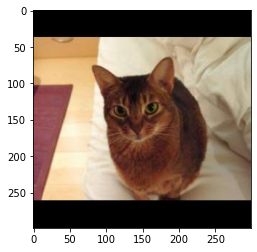

<PIL.Image.Image image mode=RGB size=299x299 at 0x23CA51F9370>
======XCeption=======
tabby: 0.4189221262931824
Egyptian_cat: 0.33469563722610474
tiger_cat: 0.09419803321361542



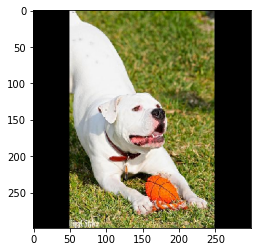

<PIL.Image.Image image mode=RGB size=299x299 at 0x23C60F20AF0>
======XCeption=======
American_Staffordshire_terrier: 0.3955667018890381
boxer: 0.3851345181465149
Staffordshire_bullterrier: 0.09358996897935867



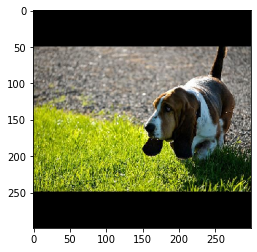

<PIL.Image.Image image mode=RGB size=299x299 at 0x23CD9ABE250>
======XCeption=======
basset: 0.9539581537246704
bloodhound: 0.0026783798821270466
Welsh_springer_spaniel: 0.0014853624161332846



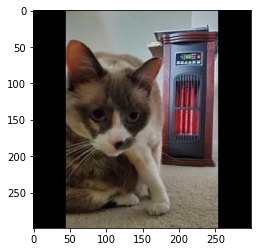

<PIL.Image.Image image mode=RGB size=299x299 at 0x23CE78106D0>
======XCeption=======
space_heater: 0.2141566127538681
Egyptian_cat: 0.1169542595744133
Siamese_cat: 0.04099031537771225



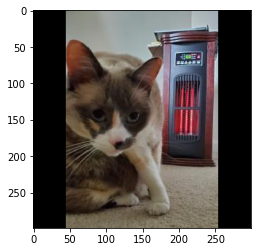

<PIL.Image.Image image mode=RGB size=299x299 at 0x23CE78B3160>
======XCeption=======
space_heater: 0.6986966133117676
Egyptian_cat: 0.029767202213406563
Siamese_cat: 0.012574445456266403



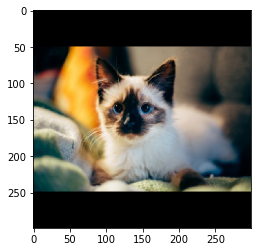

<PIL.Image.Image image mode=RGB size=299x299 at 0x23CE77E6A00>
======XCeption=======
Siamese_cat: 0.8503796458244324
Egyptian_cat: 0.0048280563205480576
lynx: 0.002782534807920456



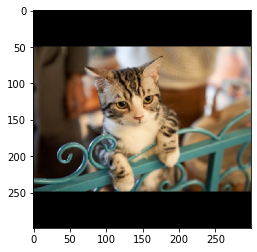

<PIL.Image.Image image mode=RGB size=299x299 at 0x23CE78507F0>
======XCeption=======
tabby: 0.27354979515075684
Egyptian_cat: 0.14784076809883118
tiger_cat: 0.10792098939418793



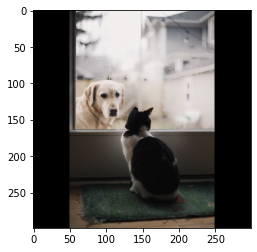

<PIL.Image.Image image mode=RGB size=299x299 at 0x23CE78219D0>
======XCeption=======
beagle: 0.1394243687391281
Cardigan: 0.056732792407274246
doormat: 0.05230780690908432



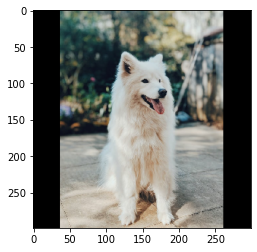

<PIL.Image.Image image mode=RGB size=299x299 at 0x23CE78C3B20>
======XCeption=======
Samoyed: 0.7274409532546997
white_wolf: 0.17472274601459503
Arctic_fox: 0.00832550972700119



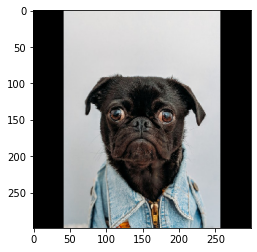

<PIL.Image.Image image mode=RGB size=299x299 at 0x23CE7850BE0>
======XCeption=======
pug: 0.629893958568573
Brabancon_griffon: 0.19039152562618256
French_bulldog: 0.006194845773279667



In [53]:
from tensorflow.keras.applications.xception import preprocess_input as xception_preprocess_input
from tensorflow.keras.applications.xception import decode_predictions as xception_decode_predictions

#name_model_shape_preprocess_decode_list = [
#    ('Xception', Xception(weights="imagenet"), (299, 299), xception_preprocess_input, xception_decode_predictions),
#    ('MobileNetV2', MobileNetV2(weights="imagenet"), (224, 224), mobile_preprocess_input, mobile_decode_predictions),
#    ('ResNet50', ResNet50(weights="imagenet"), (224, 224), resnet_preprocess_input, resnet_decode_predictions),
#]

Xmodel = Xception(weights="imagenet")

first_time = True

for image_name in os.listdir(resized_location):
    if image_name.startswith('.'): continue # Avoid looking at hidden files, which the OS sometimes puts in the folder
    
    #ImageNet is a project which aims to provide a large image database for research purposes. 
    #It contains more than 14 million images which belong to more than 20,000 classes 
    #( or synsets ). They also provide bounding box annotations for around 1 million images,
    #which can be used in Object Localization tasks.  
    image = keras_image.load_img(resized_location + image_name, target_size=(299,299))
    
    # Even though the images are slightly different sizes, don't plot them several times
    #if first_time:
    plt.imshow(image)
    plt.show()
    first_time = False
    
    print(image)
    
    # Awkward because our model is trained in batches, we have to be explicit that 
    # we're providing one example.
    array = keras_image.img_to_array(image)
    array = np.expand_dims(array, axis=0)
    array = xception_preprocess_input(array)
    label = Xmodel.predict(array)

    #print(label)

    pretty_labels = '\n'.join([f'{name}: {prob}' for _, name, prob in xception_decode_predictions(label, top=3)[0]])

    print(f'======XCeption=======\n{pretty_labels}\n')

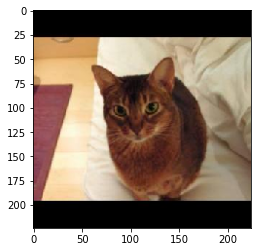

<PIL.Image.Image image mode=RGB size=224x224 at 0x23D05775370>
======mobilenetv2=======
Egyptian_cat: 0.8148837685585022
tabby: 0.060552600771188736
tiger_cat: 0.023793086409568787



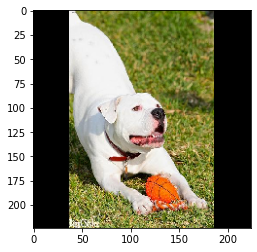

<PIL.Image.Image image mode=RGB size=224x224 at 0x23D0591C3D0>
======mobilenetv2=======
boxer: 0.4739580452442169
American_Staffordshire_terrier: 0.2232750952243805
Staffordshire_bullterrier: 0.20365716516971588



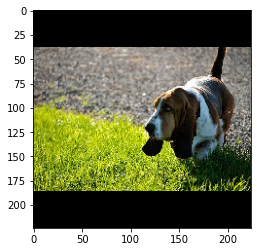

<PIL.Image.Image image mode=RGB size=224x224 at 0x23D040D1F70>
======mobilenetv2=======
basset: 0.9426285624504089
beagle: 0.012110297568142414
Walker_hound: 0.010102021507918835



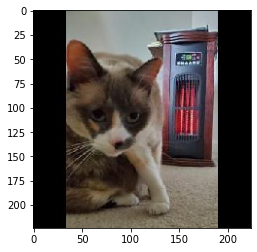

<PIL.Image.Image image mode=RGB size=224x224 at 0x23D059BA8E0>
======mobilenetv2=======
Egyptian_cat: 0.4215182960033417
Siamese_cat: 0.17290334403514862
tabby: 0.039868492633104324



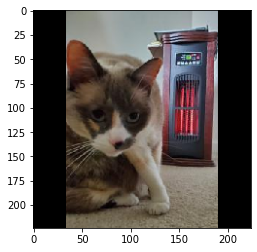

<PIL.Image.Image image mode=RGB size=224x224 at 0x23D059B3E80>
======mobilenetv2=======
Egyptian_cat: 0.20181694626808167
Siamese_cat: 0.1195468083024025
tabby: 0.06846917420625687



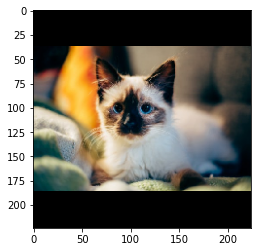

<PIL.Image.Image image mode=RGB size=224x224 at 0x23D05969B20>
======mobilenetv2=======
Siamese_cat: 0.8834210634231567
papillon: 0.010128607042133808
Chihuahua: 0.004295093007385731



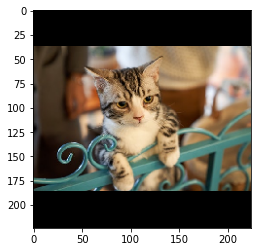

<PIL.Image.Image image mode=RGB size=224x224 at 0x23D05969640>
======mobilenetv2=======
tiger_cat: 0.33730942010879517
television: 0.1560671478509903
Egyptian_cat: 0.10075707733631134



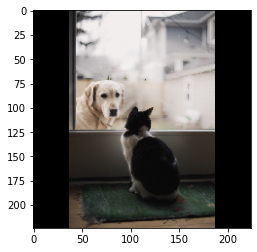

<PIL.Image.Image image mode=RGB size=224x224 at 0x23CE6958460>
======mobilenetv2=======
Chihuahua: 0.16843895614147186
toy_poodle: 0.06790278851985931
teddy: 0.04982014745473862



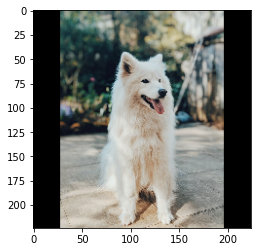

<PIL.Image.Image image mode=RGB size=224x224 at 0x23D1CF7F430>
======mobilenetv2=======
Samoyed: 0.810796320438385
white_wolf: 0.06258898228406906
Pomeranian: 0.014469624496996403



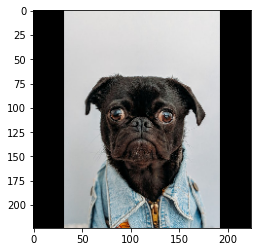

<PIL.Image.Image image mode=RGB size=224x224 at 0x23D1CF7F190>
======mobilenetv2=======
pug: 0.8460649847984314
Brabancon_griffon: 0.09464608877897263
Boston_bull: 0.0017880004597827792



In [54]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_v2_preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import decode_predictions as mobilenet_v2_decode_predictions

#name_model_shape_preprocess_decode_list = [
#    ('Xception', Xception(weights="imagenet"), (299, 299), xception_preprocess_input, xception_decode_predictions),
#    ('MobileNetV2', MobileNetV2(weights="imagenet"), (224, 224), mobile_preprocess_input, mobile_decode_predictions),
#    ('ResNet50', ResNet50(weights="imagenet"), (224, 224), resnet_preprocess_input, resnet_decode_predictions),
#]

MNV2model = MobileNetV2(weights="imagenet")

first_time = True

for image_name in os.listdir(resized_location):
    if image_name.startswith('.'): continue # Avoid looking at hidden files, which the OS sometimes puts in the folder
    
    #ImageNet is a project which aims to provide a large image database for research purposes. 
    #It contains more than 14 million images which belong to more than 20,000 classes 
    #( or synsets ). They also provide bounding box annotations for around 1 million images,
    #which can be used in Object Localization tasks.  
    image = keras_image.load_img(resized_location + image_name, target_size=(224,224))
    
    # Even though the images are slightly different sizes, don't plot them several times
    #if first_time:
    plt.imshow(image)
    plt.show()
    first_time = False
    
    print(image)
    
    # Awkward because our model is trained in batches, we have to be explicit that 
    # we're providing one example.
    array = keras_image.img_to_array(image)
    array = np.expand_dims(array, axis=0)
    array = mobilenet_v2_preprocess_input(array)
    label = MNV2model.predict(array)

    #print(label)

    pretty_labels = '\n'.join([f'{name}: {prob}' for _, name, prob in mobilenet_v2_decode_predictions(label, top=3)[0]])

    print(f'======mobilenetv2=======\n{pretty_labels}\n')

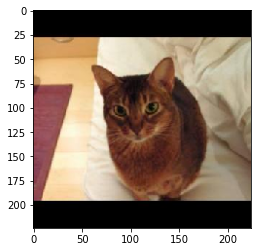

<PIL.Image.Image image mode=RGB size=224x224 at 0x23D0570E7F0>
======resnet=======
television: 0.5117185115814209
screen: 0.15374748408794403
monitor: 0.06285184621810913



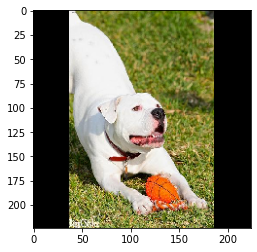

<PIL.Image.Image image mode=RGB size=224x224 at 0x23D21135B20>
======resnet=======
Staffordshire_bullterrier: 0.6448259949684143
American_Staffordshire_terrier: 0.20333857834339142
boxer: 0.07792701572179794



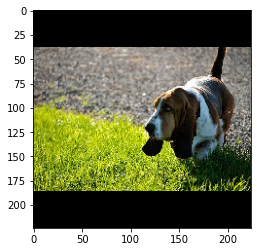

<PIL.Image.Image image mode=RGB size=224x224 at 0x23D1CE65D30>
======resnet=======
basset: 0.9818570017814636
beagle: 0.014767573215067387
Walker_hound: 0.0024090944789350033



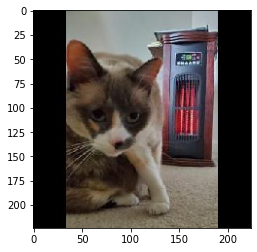

<PIL.Image.Image image mode=RGB size=224x224 at 0x23D3530FFA0>
======resnet=======
television: 0.548990786075592
screen: 0.060720495879650116
monitor: 0.051188528537750244



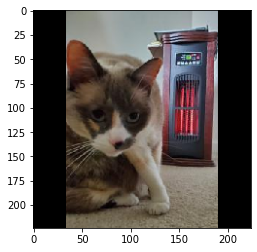

<PIL.Image.Image image mode=RGB size=224x224 at 0x23D1CF93160>
======resnet=======
television: 0.44554603099823
screen: 0.08295457065105438
monitor: 0.07617481797933578



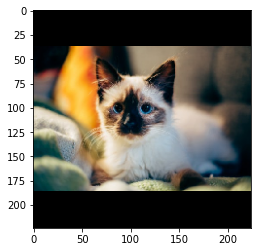

<PIL.Image.Image image mode=RGB size=224x224 at 0x23D353D6B20>
======resnet=======
Siamese_cat: 0.7507314085960388
monitor: 0.09758145362138748
television: 0.05887904018163681



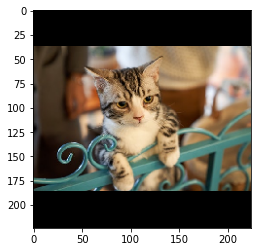

<PIL.Image.Image image mode=RGB size=224x224 at 0x23D3D61F160>
======resnet=======
screen: 0.21598249673843384
television: 0.18334759771823883
Egyptian_cat: 0.16640977561473846



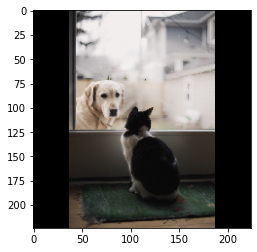

<PIL.Image.Image image mode=RGB size=224x224 at 0x23D1CEC1460>
======resnet=======
sliding_door: 0.3976961076259613
television: 0.1328519582748413
dishwasher: 0.08872175216674805



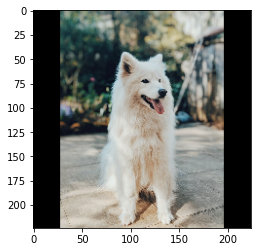

<PIL.Image.Image image mode=RGB size=224x224 at 0x23D3D6C1CA0>
======resnet=======
Samoyed: 0.5112214684486389
white_wolf: 0.47252577543258667
Eskimo_dog: 0.007128152064979076



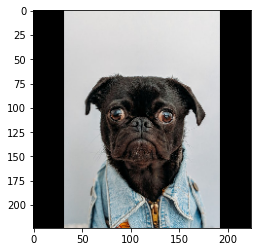

<PIL.Image.Image image mode=RGB size=224x224 at 0x23D3D6E2D90>
======resnet=======
pug: 0.8330824375152588
Brabancon_griffon: 0.16053619980812073
Boston_bull: 0.0009193058940581977



In [55]:
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras.applications.resnet50 import decode_predictions as resnet50_decode_predictions

#name_model_shape_preprocess_decode_list = [
#    ('Xception', Xception(weights="imagenet"), (299, 299), xception_preprocess_input, xception_decode_predictions),
#    ('MobileNetV2', MobileNetV2(weights="imagenet"), (224, 224), mobile_preprocess_input, mobile_decode_predictions),
#    ('ResNet50', ResNet50(weights="imagenet"), (224, 224), resnet_preprocess_input, resnet_decode_predictions),
#]

ResNet = ResNet50(weights="imagenet")

first_time = True

for image_name in os.listdir(resized_location):
    if image_name.startswith('.'): continue # Avoid looking at hidden files, which the OS sometimes puts in the folder
    
    #ImageNet is a project which aims to provide a large image database for research purposes. 
    #It contains more than 14 million images which belong to more than 20,000 classes 
    #( or synsets ). They also provide bounding box annotations for around 1 million images,
    #which can be used in Object Localization tasks.  
    image = keras_image.load_img(resized_location + image_name, target_size=(224,224))
    
    # Even though the images are slightly different sizes, don't plot them several times
    #if first_time:
    plt.imshow(image)
    plt.show()
    first_time = False
    
    print(image)
    
    # Awkward because our model is trained in batches, we have to be explicit that 
    # we're providing one example.
    array = keras_image.img_to_array(image)
    array = np.expand_dims(array, axis=0)
    array = resnet50_preprocess_input(array)
    label = ResNet.predict(array)

    #print(label)

    pretty_labels = '\n'.join([f'{name}: {prob}' for _, name, prob in resnet50_decode_predictions(label, top=3)[0]])

    print(f'======resnet=======\n{pretty_labels}\n')

In [56]:
# One really cool thing you can do with convolutional neural nets is visualize the activation maps
# which can give insight into what the convolutional kernels might be doing, and especially 
# about which areas of the image the CNN is focused on.
import cv2
import matplotlib.image as mpimg
from tensorflow.keras import backend as K


def cam(image_path, model, desired_shape, preprocess_input, decode_predictions, final_conv_name, ax):
    # This should look familiar from the above.
    # We're just loading the image and getting our networks prediction 
    image = keras_image.load_img(image_path, target_size=desired_shape)
    input_data = keras_image.img_to_array(image)
    input_data = np.expand_dims(input_data, axis=0)
    input_data = preprocess_input(input_data)
    
    # Use the model to make a prediction so we can label the image later.
    preds = model.predict(input_data)
    predictions = decode_predictions(preds, top=3)
    
    # We also get the output values for the final layer related to the top prediction. 
    top_prediction = np.argmax(preds[0])
    output = model.output[:, top_prediction]
    
    # We have to fetch the results of the final convolutional layer
    # Because the graidents of that layer will tell us which pixels
    # Contributed most to our models decision
    last_conv_layer = model.get_layer(final_conv_name)

    # And now we want to get the mean gradient intensity of 
    # all the filters in that layer. We use 'output' here to 
    # compute the gradient for the output associated with the 
    # top prediction. 
    grads = K.gradients(output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
    # This essentially creates a function that acts as a model, but where
    # it's easier to get the values out that we want. 
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    pooled_grads_value, conv_layer_output_value = iterate([input_data])
    
    # Using the avg gradient and the last conv layer's output
    # calculate the weight of each pixel's contribution. 
    for i, pooled_gradient_value in enumerate(pooled_grads_value):
        conv_layer_output_value[:, :, i] *= pooled_gradient_value
    
    # Build the heatmap
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)

    # Load the image with openCV
    img = cv2.imread(image_path)

    # Resize the heatmap, since the final conv layer isn't the same size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # Move to RGB values as ints 0-255 instead of floats 0-1
    heatmap = np.uint8(255 * heatmap)
    
    # Build the heatmap numerically
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    hif = .8
    superimposed_img = heatmap * hif + img
    
    # Save it, hilariously, so that we can show it with matplotlib
    output = 'heatmaps/output.jpeg'
    cv2.imwrite(output, superimposed_img)
    img = mpimg.imread(output)

    # Show it.
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(predictions[0][0][1])

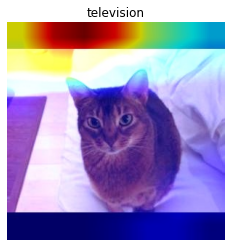

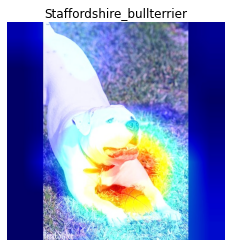

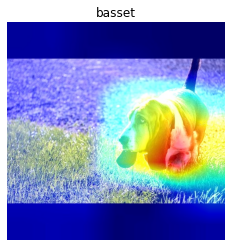

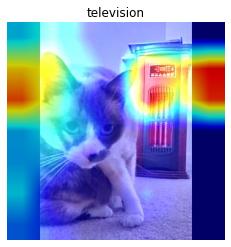

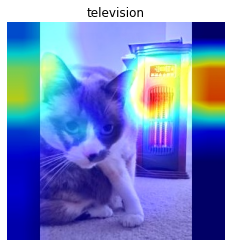

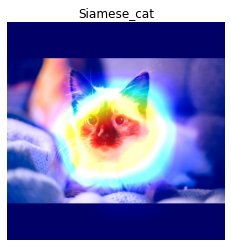

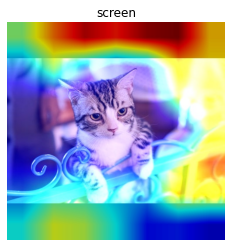

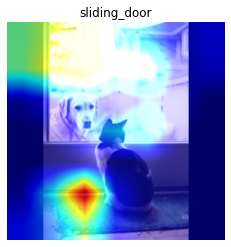

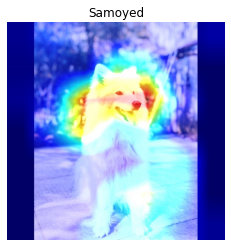

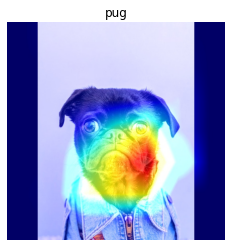

In [98]:
final_layer_names = [
    'block14_sepconv2',
    'Conv_1',
    'conv5_block3_3_conv'
]


for image_name in os.listdir(resized_location):
    if image_name.startswith('.'): continue # Avoid looking at hidden files, which the OS sometimes puts in the folder
    fig, axs = plt.subplots()
    
    #for i, (name, model, shape, preprocess, decode) in enumerate(name_model_shape_preprocess_decode_list):
        
    #for i in range(0, 3):
    #ax = axs[0]
    #final_layer_name = final_layer_name[i]
    cam(resized_location + image_name,ResNet, (224,224), resnet50_preprocess_input, resnet50_decode_predictions, 'conv5_block3_3_conv', axs)
    plt.show()